# Manipulating (Sub)Millimeter Wavelength Spectral Line Datasets

As we start on the next phase, the first step is to gain some familiarity with the kinds of data we're working with.  The basic data product is a position-position-velocity "cube", a map of emission from a spectral line as a function of the 2D position on the sky at a sequence of velocities (or frequencies).  

First, an aside on where the emission comes from.  The emission mechanism here is analogous to the standard quantum mechanics example for a hydrogen atom.  We will primarily consider simple diatomic molecules like carbon monoxide (CO).  The rotational energy states of such a molecule's center of mass are quantized: transitions between discrete energy states (from higher to lower) result in the emission of photons.  For CO, the photon energies from these "pure rotational transitions" correspond to integer multiples of the ground-state energy: for example, emission from the $J$=1$-$0 transition has a rest frequency of 115.258 GHz, $J$=2$-$1 at 230.538 GHz, $J$=3$-$2 at 345.796 GHz, etc.  These correspond to wavelengths ($\lambda = c / \nu$) of 2.6, 1.3, 0.87 mm, respectively.  

The best way to learn is to start with a data cube.  Let's download one from one of my previous projects.  These are observations of the CO $J$=2$-$1 emission line from a nearby disk:

In [1]:
import os, sys
import numpy as np
import urllib.request
import matplotlib.pyplot as plt
from astropy.io import fits
%matplotlib inline

# filename of interest
file = 'HD163296_CO.fits'

# download site
site = 'https://bulk.cv.nrao.edu/almadata/lp/DSHARP/images/'

# grab file (1.6 GB)
# urllib.request.urlretrieve(site+file, file)

A '.fits' file is a common image format used in astronomy.  The astropy package has some easy-to-use functionality for accessing its contents:

In [2]:
# load the cube and "header" information
data = fits.open('../' +file)
cube = np.squeeze(data[0].data)
hdr = data[0].header

# cube shape
print(cube.shape)

(105, 2000, 2000)


The cube is a 3-D array.  The first dimension is velocity, where the emission distribution is broken down into 105 distinct velocities, known as "channels" (for the same reason your TV or radio has channels, actually).  The other two dimensions are spatial "pixel" coordinates, one being the "right ascension" (RA) -- equivalent to longitude on the "celestial sphere" (the projection of the sky up from the Earth) -- and "declination" (DEC) -- equivalent to latitude.  The same spatial coordinates are present for each velocity channel.  We can convert between pixel and channel indices and actual physical coordinate values using information in the .fits header (which is a python dictionary):  

In [3]:
# SPATIAL
# number of pixels in each dimensions
nRA, nDEC = hdr['NAXIS1'], hdr['NAXIS2']

# convert pixel indices to RA, DEC (each in units of degrees on the sky)
RA = hdr['CRVAL1'] + hdr['CDELT1'] * (np.arange(nRA) - (hdr['CRPIX1'] - 1))
DEC = hdr['CRVAL2'] + hdr['CDELT2'] * (np.arange(nDEC) - (hdr['CRPIX2'] - 1))

# convert these to offsets from the image center, in **arcseconds** units (1 degree = 3600 arcseconds)
RAo, DECo = 3600 * (RA - hdr['CRVAL1']), 3600 * (DEC - hdr['CRVAL2'])

# in some cases, the emission center (= location of star, which we don't see in these data) is offset from the 
# image center; we can correct for that to have a coordinate frame on the sky, centered on the star position
# (note: these shifts are quite small in this case, but for clarity, here's how you do it)
offRA, offDEC = -0.02, 0.00    # the offsets (measured elsewhere)
dRAo, dDECo = RAo - offRA, DECo - offDEC

# now create a 2-D grid of RA and DEC offsets (relative to emission center) for each pixel in the cube
dRA, dDEC = np.meshgrid(dRAo, dDECo)

# SPECTRAL
# number of channels
nchan = hdr['NAXIS3']

# convert channel indices to frequencies (in units of Hz)
freq = hdr['CRVAL3'] + hdr['CDELT3'] * (np.arange(nchan) - (hdr['CRPIX3'] - 1))

# use the Doppler formula to calculate the corresponding velocities (in units of km/s)
c_ = 2.99792e5       # speed of light in km/s
freq0 = 230.538e9    # rest frequency of CO J=2-1 line in Hz
vel = c_ * (1. - freq / freq0)

Ok, so now we can plot an image from the cube with the proper coordinates.  We call this spectral slice of the cube a "channel map", the spatial distribution of the emission from a given velocity:

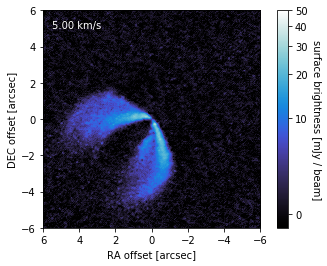

In [35]:
import cmasher as cmr          # color maps
from astropy.visualization import (AsinhStretch, LogStretch, ImageNormalize)    # image visualization functions

# channel index to plot
ch_idx = 50

# define the full image boundaries with a list of the min/max RA and DEC offsets
# (note the reverse ordering for RA, since this is plotted with E to the left)
im_bounds = (dRA.max(), dRA.min(), dDEC.min(), dDEC.max())

# now set the RA and DEC offset ranges you want to show
dRA_lims  = [6, -6]      # (same reverse ordering to ensure E is to the left)
dDEC_lims = [-6, 6]

# now define the color-map, intensity limits, and stretch
cmap = cmr.freeze
vmin, vmax = -1, 50   # these are in mJy/beam units
norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=AsinhStretch())

# set up and plot the image on the specified scale
fig, ax = plt.subplots()
im = ax.imshow(1e3*cube[ch_idx,:,:], origin='lower', cmap=cmap, extent=im_bounds, norm=norm, aspect='equal')
ax.set_xlim(dRA_lims)
ax.set_ylim(dDEC_lims)
ax.set_xlabel('RA offset [arcsec]')
ax.set_ylabel('DEC offset [arcsec]')

# add a scalebar
cb = plt.colorbar(im, ax=ax, pad=0.05)
cb.set_label('surface brightness [mJy / beam]', rotation=270, labelpad=13)

# annotate with the velocity
vel_str = '%.2f km/s' % vel[ch_idx]
ax.text(5.5, 5.0, vel_str, color='w');

The surface brightness units here are mJy / beam, or "milliJansky per beam".  The native units of .fits files for ALMA data are Jy / beam.  The "Jansky" is a common unit in radio astronomy, where 1 Jy = 10$^{-23}$ ergs / s / cm$^2$ / Hz.  The "per beam" part is also common, but it's super confusing even to astronomers.  The "beam" is a measure of the spatial resolution of the observations: it tells you how light from a point source (i.e., a source with infinitesimally small size) would be smeared out by the instrument.  Sometimes a beam is called a "point spread function" for that same reason.  As you'll learn more about later, this "beam" is a 2-D elliptical Gaussian distribution, so the "per beam" designation is the effective area of that 2-D Gaussian.  If this elliptical beam has a full-width-at-half-maximum (FWHM) major axis of $a$ and a FWHM minor axis of $b$, the beam area being referenced is:

$\Omega_{\rm beam} = \frac{\pi \, a \, b}{4 \, \ln{2}}$.

Normally we can access the values of $a$ and $b$ from the .fits header, but for esoteric reasons this particular file is missing them.  In this case, $a = 0.104$ arcseconds (denoted $^{\prime\prime}$) and $b = 0.095^{\prime\prime}$.  So the beam area is $\Omega_{\rm beam} = 0.011$ arcseconds$^2$.

Frequently, radio astronomers instead choose to quote surface brightnesses $I_\nu$ (as above) in a different format.  Then, we speak of "brightness temperatures", $T_b$.  In the most formal sense, $T_b$ is the temperature that matches the surface brightness so that $I_\nu = B_\nu(T_b)$, where $B_\nu$ is the Planck function.  But in common usage, we assume the Rayleigh-Jeans limit applies (technically it doesn't!), so that 

$I_\nu = \frac{2 \, k_B \, \nu^2 \, T_b}{c^2}$

where $\nu$ is the frequency, $k_B$ is the Boltzmann constant, and $c$ is the speed of light.  The conversion seems straightforward, but the units _often_ thwart people.  The key is to convert $I_\nu$ into CGS units, noting that the appropriate unit for an area on the sky (i.e., the beam area) is _steradians_, or square radians (rather than square arcseconds).  Its useful to be facile with this brightness convention transformation.  Write a function to do it:

In [74]:
# def convert_cgs(I_v, a, b): #I_v in Jy/beam; a, b in arcsec
#     SI_area = np.pi*a*b/(4*np.log(2)) # in arcsec^2 units
#     tojansky = I_v*SI_area #in Jy units
#     toerg = tojansky*1e-23 # in erg Hz^-1 s^-1 cm^-2 units
#     sqrad=SI_area*4.25e-10 #in str units; 4.25e-10 str = 1 arcsec^2
#     tocgs = toerg/sqrad
#     print('%s erg Hz^-1 s^-1 cm^-2 st^-1' % tocgs) 
#     boltzc = 1.380649e-16 # in erg/K
#     T_b = (toerg * (c_*1e5)**2)/((2*freq0**2)*boltzc) # in Kelvin
#     print('%s K' % T_b)    

#convert_cgs(-0.001, 0.104, 0.095)

def to_cgs(I_v, a, b):
    SI_area = np.pi*a*b/(4*np.log(2)) # in arcsec^2 units
    tojansky = I_v*SI_area #in Jy units
    toerg = tojansky*1e-23 # in erg Hz^-1 s^-1 cm^-2 units
    boltzc = 1.380649e-16 # in erg/K
    T_b = (toerg * (c_*1e5)**2)/((2*freq0**2)*boltzc) # in Kelvin
    print("%s K" % T_b)

to_cgs(-0.001, 0.104, 0.095)
to_cgs(0.05, 0.104, 0.095)

-6.8558786687483735e-15 K
3.427939334374187e-13 K


Now plot the same channel map as above, but on a $T_b$ scale instead of a mJy / beam scale:

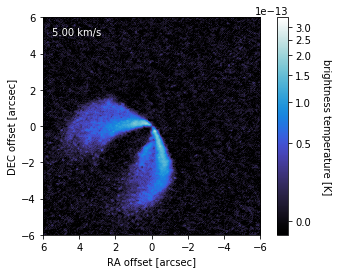

In [6]:
# now define the color-map, intensity limits, and stretch
cmap = cmr.freeze
vmin, vmax = -6.85e-15, 3.43e-13   # these are in K units
norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=AsinhStretch())

# set up and plot the image on the specified scale
fig, ax = plt.subplots()
im = ax.imshow(to_cgs(cube[ch_idx,:,:], 0.104, 0.095), origin='lower', cmap=cmap, extent=im_bounds, norm=norm, aspect='equal')
ax.set_xlim(dRA_lims)
ax.set_ylim(dDEC_lims)
ax.set_xlabel('RA offset [arcsec]')
ax.set_ylabel('DEC offset [arcsec]')

# add a scalebar
cb = plt.colorbar(im, ax=ax, pad=0.05)
cb.set_label('brightness temperature [K]', rotation=270, labelpad=20)

# annotate with the velocity
vel_str = '%.2f km/s' % vel[ch_idx]
ax.text(5.5, 5.0, vel_str, color='w');

The full data cube includes a large number of channels in the typical case.  Here, we have 105.  Usually we want to look at all of them together on a grid, since that reveals important information about the disk kinematics.  Make a set of 100 channel maps in a 10x10 grid.  You can plot them all on the same brightness scale, so the scalebar isn't necessary (for now).  This should be coded in a loop, and I'd strongly recommend you use the matplotlib.gridspec functionality.

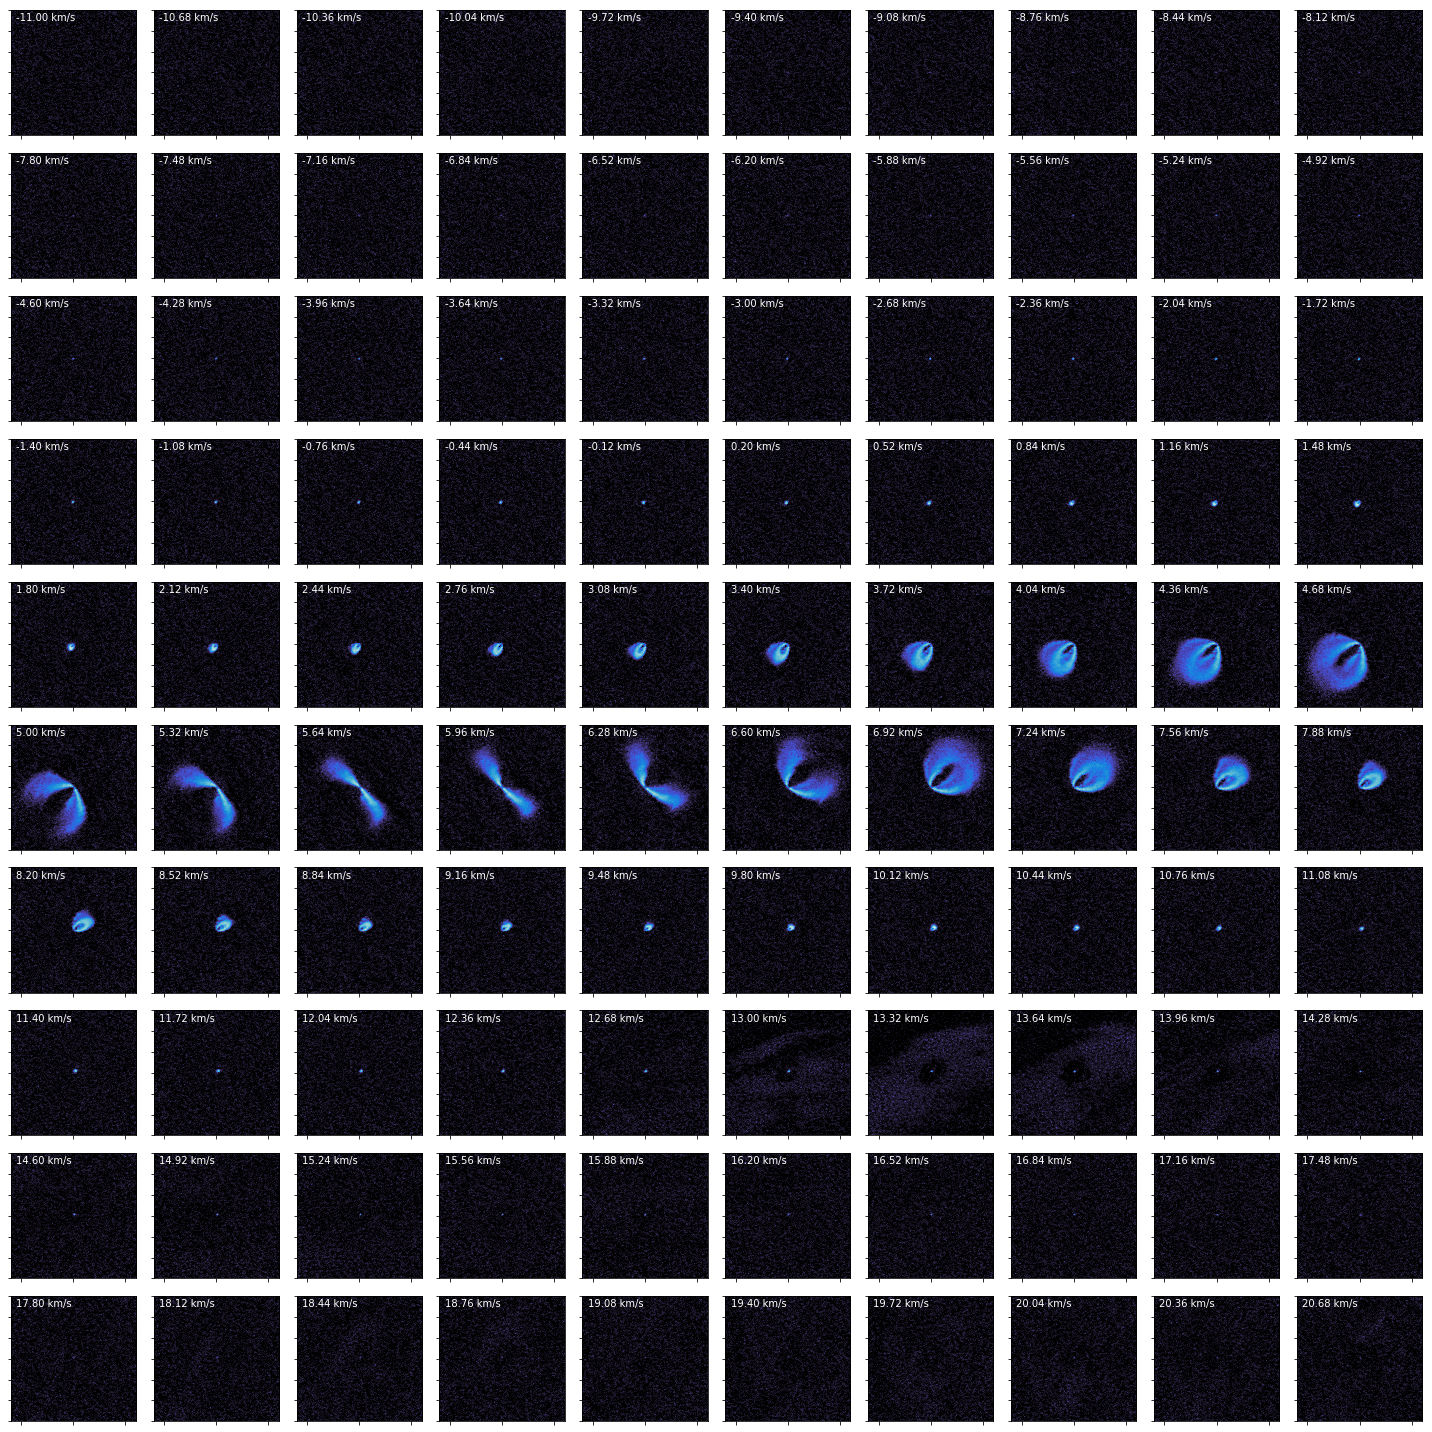

In [61]:
import matplotlib.gridspec as gridspec

n=10
axes = ['ax'+ str(i) for i in range(n**2)]
ch_idx = np.arange(100)

c = np.arange(n)
r = np.arange(n)
cols, rows = np.meshgrid(c, r)
points = np.column_stack((np.ravel(rows), np.ravel(cols)))

fig = plt.figure(tight_layout=True, figsize=(20,20))
spec = gridspec.GridSpec(ncols=n, nrows=n, figure=fig)
        
for i in range(len(axes)):  
    axes[i] = fig.add_subplot(spec[points[i][0], points[i][1]])
    axes[i].imshow(1e3*cube[ch_idx[i],:,:], origin='lower', cmap=cmap, extent=im_bounds, norm=norm, aspect='equal')
    axes[i].set_xlim(dRA_lims)
    axes[i].set_ylim(dDEC_lims)
    plt.setp(axes[i].get_xticklabels(), visible=False)
    plt.setp(axes[i].get_yticklabels(), visible=False)        
    # annotate with the velocity
    vel_str = '%.2f km/s' % vel[ch_idx[i]]
    axes[i].text(5.5, 5.0, vel_str, color='w');

Try to digest some of the "patterns" you see in these channel maps.  How are the general spatial and kinematic (spectral) variations in the emission related?

In [69]:
#To save images:
# for i in range(len(axes)):  
#     fig, ax = plt.subplots()
#     ax.imshow(1e3*cube[ch_idx[i],:,:], origin='lower', cmap=cmap, extent=im_bounds, norm=norm, aspect='equal')
#     ax.set_xlim(dRA_lims)
#     ax.set_ylim(dDEC_lims)
#     plt.setp(ax.get_xticklabels(), visible=False)
#     plt.setp(ax.get_yticklabels(), visible=False)        
#     # annotate with the velocity
#     vel_str = '%.2f km/s' % vel[ch_idx[i]]
#     ax.text(5.5, 5.0, vel_str, color='w');
#     fig.savefig('image%s.png' % i, bbox_inches='tight')